# West Nile Virus analysis: spatial factors and prediction  
## Mid-term draft 
Hanpu Yao  
Professor Jonanthan Tannen



### Proposals: 

**Goal**: find the high risk area of West Nile Virus and allocate pesticide accordingly.  
-	Predict the time and place that WNV may propably present  

**Dataset**:
1.	Main data: mosquitos captured in traps (2007/5 – 2021/9):  
Time,
Location, 
Mosquitoes(number, spiecies, WNV positivity)


2.	Spray Data: spraying pesticide to kill mosquitos (2011/8 – 2013/9 will reach out for more data) 
Time
Location (area)

3.	Weather Data – WNV prefers hot and dry environment: 
Rain, 
Wind, 
Temperature, 
Moisture
		
4.	Bird - Report positive case of dead bird

5.	Urban environment – 311 sanitation report

6.	Natural environment location: Parks, water


**Mid term status:**

wrangling data to visualize and see what is the probable relationship.

**Problem**

1. Spray data only contain one year and City of Chicago didn't reply yet. For now I maybe have to narrow down the time span to that one year. And if they give the whole data then I can add them in and run the same process.
2. There are temperal and spatial factors, so I have to find a proper way to handle this two dimension best.
+ Temperal factors: 
1. Pesticide effect over time
2. Positive cases in past days may affect cases in future days (if no pesticide sprayed)

+ Spatial factors:
1. Distantce to park, lakes, river or dirty place.
2. Wind effect: positive cases in upwind area may affect downwind area.



In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px #
from sodapy import Socrata # api
import missingno as msno # check NAs
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline

mosquitos data

In [2]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("jqe8-8r6s", limit=60000)

# Convert to pandas DataFrame
df_trap_raw = pd.DataFrame.from_records(results)


In [3]:
df_trap_raw.tail()



,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,latitude,longitude,location,:@computed_region_43wa_7qmu,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_awaf_s7ux
32873,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29T00:05:00.000,1,negative,CULEX PIPIENS/RESTUANS,42.01780085,-87.687601446,"{'latitude': '42.0178008501155', 'longitude': ...",5,341,22528,20,3
32874,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29T00:05:00.000,1,negative,CULEX PIPIENS/RESTUANS,41.68817059,-87.678251676,"{'latitude': '41.688170589570205', 'longitude'...",42,378,22212,74,33
32875,2007,21,20051,2XX W 89TH ST,T096,CDC,2007-05-29T00:05:00.000,5,negative,CULEX RESTUANS,41.732428064,-87.63105648,"{'latitude': '41.73242806400838', 'longitude':...",13,187,21554,45,18
32876,2007,21,20031,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00.000,2,negative,CULEX PIPIENS/RESTUANS,41.922512377,-87.63237767,"{'latitude': '41.922512376871495', 'longitude'...",34,207,21190,68,51
32877,2007,21,20027,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00.000,3,negative,CULEX RESTUANS,41.922512377,-87.63237767,"{'latitude': '41.922512376871495', 'longitude'...",34,207,21190,68,51


In [4]:
df_trap_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32878 entries, 0 to 32877
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   season_year                  32878 non-null  object
 1   week                         32878 non-null  object
 2   test_id                      32878 non-null  object
 3   block                        32878 non-null  object
 4   trap                         32878 non-null  object
 5   trap_type                    32878 non-null  object
 6   test_date                    32878 non-null  object
 7   number_of_mosquitoes         32878 non-null  object
 8   result                       32878 non-null  object
 9   species                      32878 non-null  object
 10  latitude                     27990 non-null  object
 11  longitude                    27990 non-null  object
 12  location                     27990 non-null  object
 13  :@computed_region_43wa_7qmu  27

In [5]:
df_trap = df_trap_raw
df_trap['number_of_mosquitoes'] = df_trap_raw["number_of_mosquitoes"].astype(int)
df_trap['latitude'] = df_trap_raw["latitude"].astype(float)
df_trap['longitude'] = df_trap_raw["longitude"].astype(float)

<AxesSubplot:>

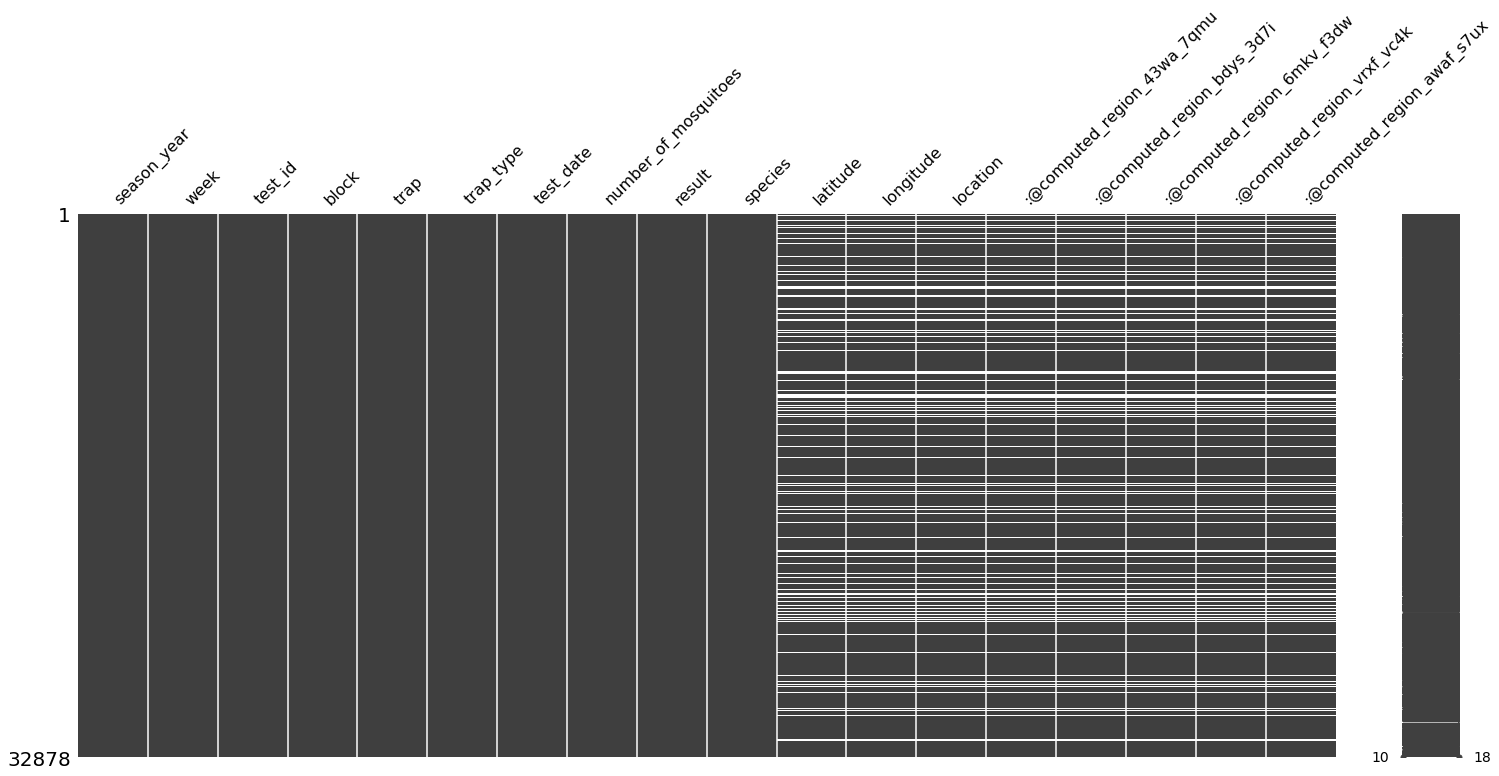

In [6]:
msno.matrix(df_trap)


<AxesSubplot:>

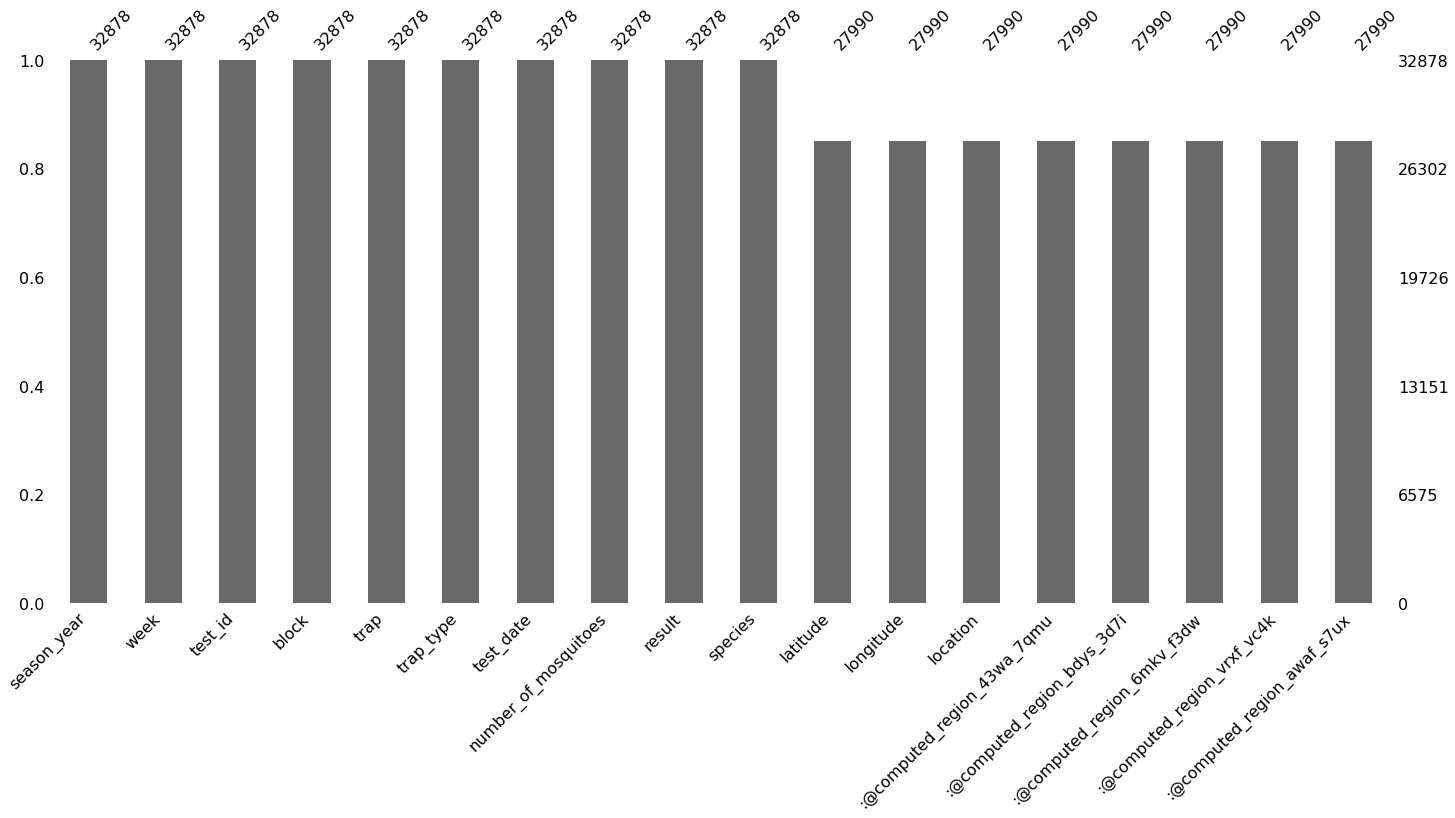

In [7]:
msno.bar(df_trap)


In [8]:
df_trap['result'].unique()

array(['negative', 'positive'], dtype=object)

In [9]:
df_trap['result_b'] =  (df_trap['result'] == 'positive').astype('int')

In [10]:
data_vis_1 = pd.DataFrame(df_trap.groupby(['season_year','trap'])['result_b'].sum()).reset_index()
data_vis_1

,season_year,trap,result_b
0,2007,T001,0
1,2007,T002,8
2,2007,T003,4
3,2007,T004,0
4,2007,T005,2
...,...,...,...
1330,2021,T909,19
1331,2021,T910,6
1332,2021,T912,1
1333,2021,T913,8


<AxesSubplot:xlabel='season_year', ylabel='result_b'>

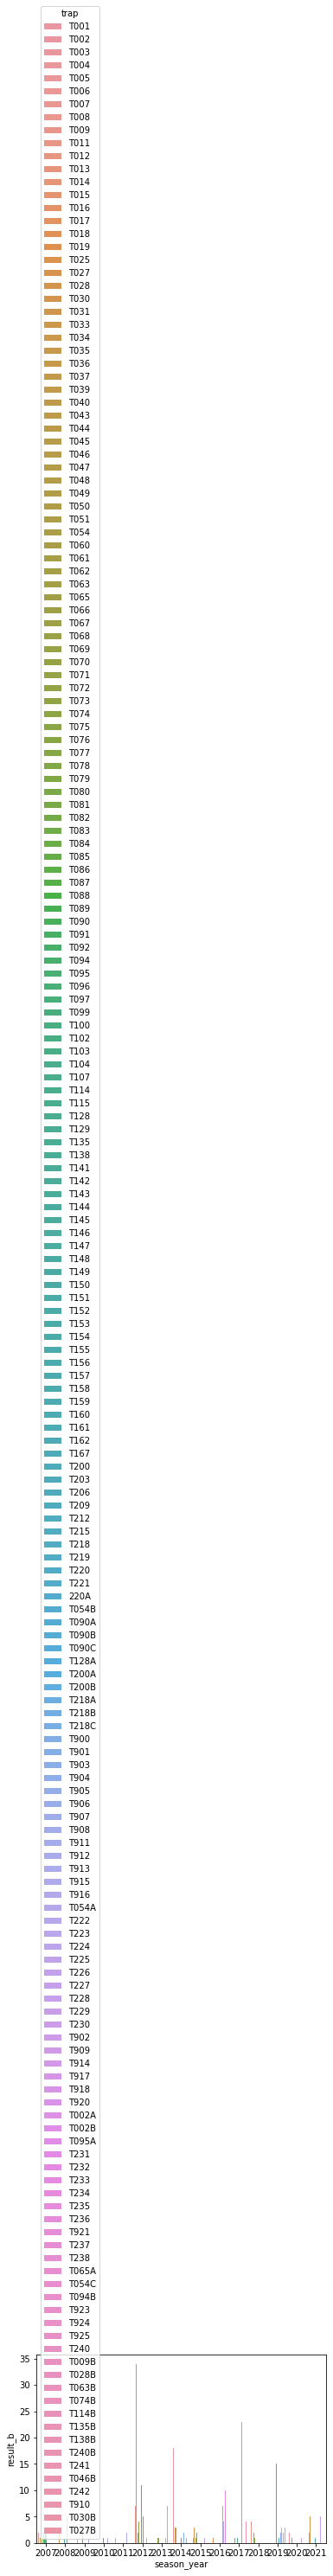

In [11]:
sns.barplot(x="season_year", y="result_b", data=data_vis_1,
            hue='trap')

In [12]:
df_trap.groupby('season_year').sum('number_of_mosquitoes')

,number_of_mosquitoes,latitude,longitude,result_b
season_year,,,,
2007,57708,144809.370100,-303686.114682,234
2008,24034,76685.872383,-160733.283860,99
2009,21108,76845.102258,-161082.407840,19
2010,21885,82503.757851,-172919.209049,76
2011,18799,70369.492017,-147498.038165,57
2012,36021,88730.903893,-185922.701268,437
2013,36444,86150.560895,-180553.627993,239
2014,37658,99886.246642,-209320.189637,211
2015,16997,58455.383002,-122507.196139,113


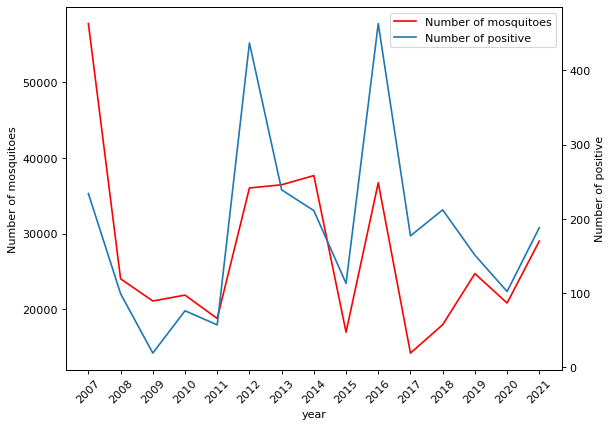

In [13]:

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)

ax.plot(
    df_trap.groupby('season_year')['number_of_mosquitoes'].sum(),
    '-r',
     label = 'Number of mosquitoes'
)

ax2 = ax.twinx()
ax2.plot(
    df_trap.groupby('season_year')['result_b'].sum(),
    '-',
   label = 'Number of positive'
)

ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel("year")
ax.set_ylabel(r'Number of mosquitoes')
ax2.set_ylabel(r'Number of positive') 

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)


In [14]:

px.set_mapbox_access_token('pk.eyJ1IjoiZHJlYW0zciIsImEiOiJja3p0ZnZwem4xbjExMnZuYTNyNm05NXFkIn0.Mn-2ZucLu2QP-9nS1UZbKA')
fig = px.scatter_mapbox(data_frame = df_trap_raw, lat = 'latitude', lon  = 'longitude', 
                        size_max=15, zoom = 9.3)

fig.update_layout(title = 'Mosquito traps location in Chicago',
    autosize=False,
    width=600,
    height=700,)

fig.show()

In [15]:
mosquitoN_and_result = pd.concat([
  df_trap.groupby(['trap','latitude','longitude'])['number_of_mosquitoes'].sum(),
  df_trap.groupby(['trap','latitude','longitude'])['result_b'].sum()],
  axis = 1
).reset_index()

In [16]:
mosquitoN_and_result.head()

,trap,latitude,longitude,number_of_mosquitoes,result_b
0,220A,41.987054,-87.728398,116,2
1,T001,41.954282,-87.733843,25,0
2,T002,41.956299,-87.797517,16271,88
3,T002A,41.965414,-87.782119,178,0
4,T002B,41.951535,-87.789835,9,0


Size is total number of mosquitoes in each trap, color is total positive times in each trap

In [17]:

plt.figure(figsize=(8, 6), dpi=80)
fig = px.scatter_mapbox(mosquitoN_and_result, lat = 'latitude', lon  = 'longitude', color = 'result_b',
                        size = 'number_of_mosquitoes', color_continuous_scale = px.colors.sequential.Viridis,
                        hover_data = ['number_of_mosquitoes', 'result_b'],
                       zoom = 9)
fig.update_layout(
    title="Total number of mosquitoes and positive times",
    width=500,
    height=700,
)

fig.show()

<Figure size 640x480 with 0 Axes>

spray data

In [18]:
spray = pd.read_csv('data/spray.csv')

In [19]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [107]:
fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',
                     animation_frame = 'Date',
                     zoom = 8)

fig.update_layout(
    title="Spray day-wise",
    width=500,
    height=700,
)

fig.show()

In [76]:
forestry = gpd.read_file("./data/Forestry/Forestry.shp")
park = gpd.read_file("data/Parks - Chicago Park District Park Boundaries (current).geojson")

In [82]:
forestry.geometry.crs

<Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [95]:
forestry.head()

,AREA,PERIMETER,FOREST_,FOREST_ID,NAME,EDIT_DATE1,FID_,SHAPE_AREA,SHAPE_LEN,geometry
0,2.144996e+07,37340.04869,1,2,CATHRINE CHEVALIER WOODS,03-21-01,None,2.144996e+07,37340.064884,"MULTIPOLYGON (((-87.84664 41.97128, -87.84664 ..."
1,1.878679e+07,48679.85682,2,8,SHILLER WOODS NORTH,03-21-01,None,1.878679e+07,48679.859013,"MULTIPOLYGON (((-87.85263 41.95649, -87.85269 ..."
2,1.507464e+06,4878.06941,3,9,SHILLER PLAYFIELD,03-21-01,None,1.507464e+06,4878.068560,"POLYGON ((-87.83190 41.95591, -87.83193 41.955..."
3,2.405552e+07,27200.18266,4,3,SHILLER WOODS SOUTH,03-21-01,None,2.405551e+07,27200.178457,"MULTIPOLYGON (((-87.85273 41.94310, -87.85272 ..."
4,5.991599e+06,16391.37539,5,10,SIDNEY YATES FLATWOODS,03-21-01,None,5.991605e+06,16391.364149,"POLYGON ((-87.77874 41.99749, -87.77903 41.997..."


In [83]:
forestry = forestry.to_crs(park.crs)

/var/folders/vj/kw0mrpx97xz6fv725_j2pfdh0000gn/T/ipykernel_31523/4149953454.py:15: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



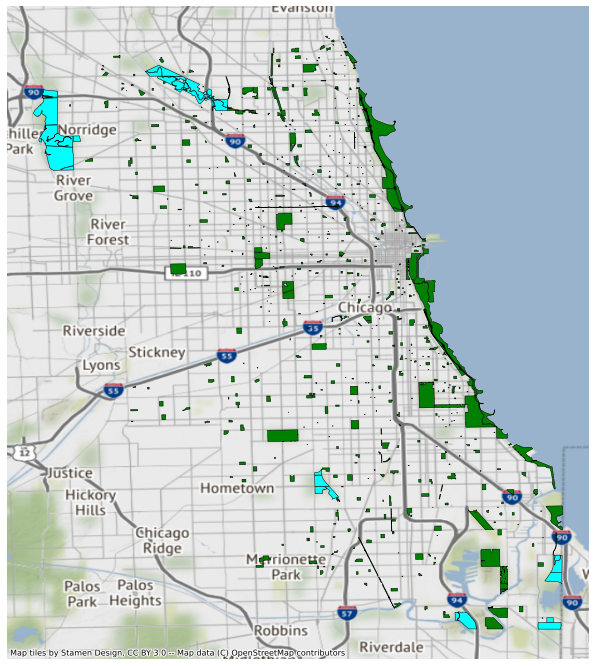

In [106]:
import contextily as ctx
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Add the forestry and park
forestry.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='cyan')
park.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='green')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=forestry.crs, source=ctx.providers.Stamen.Terrain)

# remove axis lines
ax.set_axis_off()

fig.show()

Weather

In [ ]:
weather = pd.read_csv('data/weather.csv')

In [ ]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [23]:

Trash 
street cleaning
flooding


SyntaxError: invalid syntax (1330572741.py, line 2)

Notes Mar 4:

Get down to one year data that spray has

Different before & after spray

Spatial relationship to parks and waters